In [2]:
# fileinput information
def input_data(file_name):
    file_dir = "E:\\Remote_sensing_data\\Test"
    import os
    filename = os.path.join(file_dir, file_name)
    Input_data = open(filename, "r")
    count = 0
    L = [""]
    for i in Input_data.readlines():
        if i[0] != "%" and i[0] != "\n":
            i = i.replace("\n", "")
            L.insert(count, i)
            count += 1
    L.pop(5)
    # print(L)
    Input_data.close()
    return L

# serach location of file


def file(mydir, filename):
    import os
    filelist1 = os.listdir(mydir)
    for index in filelist1:
        folder = mydir+"\\"+index
        filelist2 = os.listdir(folder)
        try:
            folder_index = filelist2.index(filename)
            if folder_index >= 0:
                folder_ind = filelist2[folder_index]
                file_location = folder+"\\"+folder_ind
                return file_location
        except ValueError as err:
            E = 1

# converting map info into pixel
def map2pix(R, Pt):
    import numpy as np
    Rn = np.zeros((3, 2))
    Rn[0, 0] = R[2]
    Rn[0, 1] = R[5]
    Rn[1, 0] = R[1]
    Rn[1, 1] = R[4]
    Rn[2, 0] = R[0]
    Rn[2, 1] = R[3]
    Y = ((Pt[:, 0]*Rn[0, 1])-(Rn[2, 0]*Rn[0, 1])+(Rn[2, 1]*Rn[0, 0]) -
         (Pt[:, 1]*Rn[0, 0]))/((Rn[1, 0]*Rn[0, 1])-(Rn[1, 1]*Rn[0, 0]))
    X = ((Pt[:, 1]-Rn[2, 1])-(Y*Rn[1, 1]))/Rn[0, 1]
    P = np.zeros(Pt.shape)
    P[:, 0] = X[:]
    P[:, 1] = Y[:]
    P = np.around(P)
    P = P.astype(int)
    return P

# converting pixel into map


def pix2map(R, Pt):
    import numpy as np
    Rn = np.zeros((3, 2))
    Rn[0, 0] = R[2]
    Rn[0, 1] = R[5]
    Rn[1, 0] = R[1]
    Rn[1, 1] = R[4]
    Rn[2, 0] = R[0]
    Rn[2, 1] = R[3]
    t = Pt @ Rn[0:2, :]
    X = t[:, 0] + Rn[2, 0]
    Y = t[:, 1] + Rn[2, 1]
    P = np.zeros(Pt.shape)
    P[:, 0] = X[:]
    P[:, 1] = Y[:]
    return P

# als to respective height based on the dem
def dem_als_hc(ad, als, als_P):
    import numpy as np
    [sxd, syd] = np.shape(ad)
    Z = np.where(ad == -9999) # false value generate while DEM generation
    X = Z[0]
    Y = Z[1]
    for i in range(len(X)):
        x = X[i]
        y = Y[i]
        Hd = ad[x, y]
        nn = 0
        nn = nn+1
        stx = x-nn
        enx = x+nn
        sty = y-nn
        eny = y+nn
        if stx < 0:
            stx = 0
        if sty < 0:
            sty = 0
        if enx > sxd:
            enx = sxd
        if eny > syd:
            eny = syd
        Hd = ad[stx:enx+1, sty:eny+1]
        Hd = np.where(Hd % -9999 == 0, 0, Hd)
        Hd = Hd[Hd > 0]
        Hd = np.mean(Hd)
        ad[x, y] = Hd
    ALSP = np.zeros(als.shape)
    ALS = np.zeros(als.shape)
    Hd = np.zeros(als.shape[0])
    Hn = np.zeros(als.shape[0])
    ALSP[:, 0:2] = als_P
    ALS[:, 0:2] = als[:, 0:2]
    HD = ad[als_P[:, 0], als_P[:, 1]]
    HN = als[:, 2]
    HN = abs(HN-HD)
    ALSP[:, 2] = HN
    ALS[:, 2] = HN
    return ad, ALS, ALSP

# non-ground lidar points
def alsabove_pt(Z):
    import numpy as np
    y = np.where(Z[:, 2] > 1.0)
    x = y[0]
    ALSabove = Z[x, :]
    return ALSabove  # , mask


In [3]:
# Read data files
Input = input_data("Input_Tas.txt")
IMGFile = Input[0]
LIDARFile  = Input[1]
DEMFile = Input[2]
LIDAR_X = float(Input[3])
LIDAR_Y = float(Input[4])
IMG_F = file("E:\Matlab_code\data",IMGFile)
LIDAR_F = file("E:\Matlab_code\data",LIDARFile)
DEM_F = file("E:\Matlab_code\data",DEMFile)

Als data is
(1748, 3)


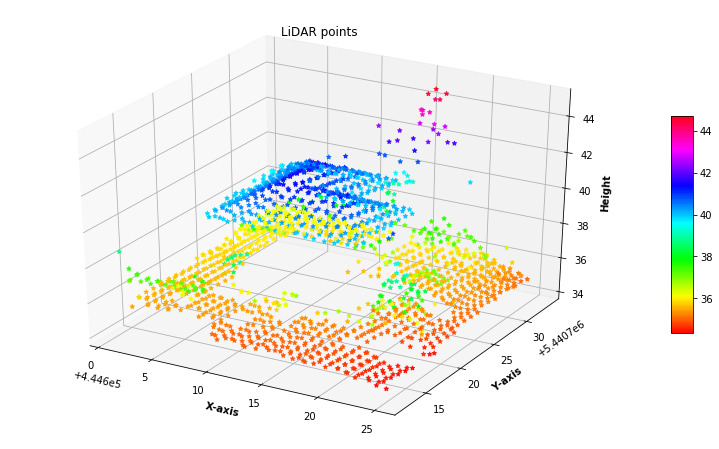

In [9]:
# import Lidar data
import numpy as np
als = np.loadtxt(LIDAR_F, dtype=np.float64)
als = als[:,0:3]
print("Als data is")
print(als.shape)


import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

x=als[:,0]
y=als[:,1]
z=als[:,2]
fig = plt.figure(figsize = (14, 8))
ax = plt.axes(projection ="3d")
my_cmap = plt.get_cmap('hsv')
scatt = ax.scatter3D(x, y, z, alpha = 0.9, c = z, cmap = my_cmap, marker ='*')
plt.title("LiDAR points")
ax.set_xlabel('X-axis', fontweight ='bold')
ax.set_ylabel('Y-axis', fontweight ='bold')
ax.set_zlabel('Height', fontweight ='bold')
fig.colorbar(scatt, ax = ax, shrink = 0.5 , aspect = 10)


 

Dem size is 37 x 38 x 1
Image size is 190 x 194 x3 


Text(0.5, 1.0, 'Color DEM')

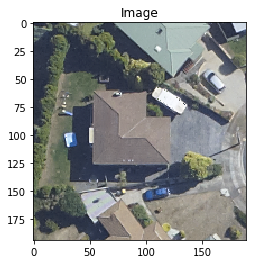

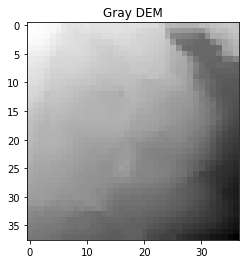

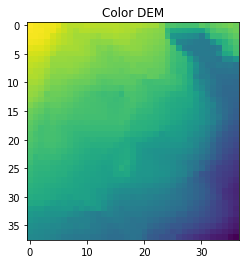

In [77]:
# import Dem data (image)
from osgeo import gdal
Ad = gdal.Open(DEM_F, gdal.GA_ReadOnly)
rd = Ad.GetGeoTransform()  # Raster info
print("Dem size is {} x {} x {}".format(Ad.RasterXSize,Ad.RasterYSize, Ad.RasterCount))  # x*y*z,  ad.shape
Ad_band = Ad.GetRasterBand(1)  # Intensity type
# min,max intensity value" ; # ad.max() or ad.min()
(ad_min, ad_max) = Ad_band.ComputeRasterMinMax(True)
ad = Ad_band.ReadAsArray()

# import remote sensing image
from osgeo import gdal
A = gdal.Open(IMG_F, gdal.GA_ReadOnly)
r = A.GetGeoTransform()  # "Raster"
print("Image size is {} x {} x{} ".format(A.RasterXSize,A.RasterYSize, A.RasterCount))  # x*y*z,  ad.shape

if A.RasterCount == 1:
    R_band = A.GetRasterBand(1)  # "Intensity type"
    ra = R_band.ReadAsArray()
elif A.RasterCount == 2:
    R_band = A.GetRasterBand(1)  # "Intensity type"
    ra = R_band.ReadAsArray()
    G_band = A.GetRasterBand(2)  # "Intensity type"
    ga = G_band.ReadAsArray()
else:
    R_band = A.GetRasterBand(1)  # "Intensity type"
    ra = R_band.ReadAsArray()
    G_band = A.GetRasterBand(2)  # "Intensity type"
    ga = G_band.ReadAsArray()
    B_band = A.GetRasterBand(3)  # "Intensity type"
    ba = B_band.ReadAsArray()
    a = np.zeros((A.RasterYSize, A.RasterXSize, A.RasterCount))
    a.shape, ra.shape
    a[:, :, 0] = ra
    a[:, :, 1] = ga
    a[:, :, 2] = ba  
    
    
import matplotlib.pyplot as plt
fig = plt.figure()
plt.imshow(a.astype(int))
plt.title('Image')
fig = plt.figure()
plt.imshow(ad, cmap = plt.cm.gray)
plt.title("Gray DEM")
fig = plt.figure()
plt.imshow(ad, cmap = None)
plt.title("Color DEM")